~~~
Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~

# Prompt MedGemma 1.5 with Whole Slide Digital Pathology Imaging

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/medgemma/blob/main/notebooks/rl_with_trl.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogle-Health%2Fmedgemma%2Fmain%2Fnotebooks%2Frl_with_trl.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/medgemma/blob/main/notebooks/rl_with_trl.ipynb">
      <img alt="GitHub logo" src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/collections/google/medgemma-release-680aade845f90bec6a3f60c4">
      <img alt="Hugging Face logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on Hugging Face
    </a>
  </td>
</tr></tbody></table>

This notebook demonstrates how to use digital pathology whole slide imaging to prompt MedGemma 1.5 loaded from Hugging Face executed locally within the Colab notebook environment.

In [18]:
# @title Install Hugging Face and [ez-wsi-dicomweb](https://colab.sandbox.google.com/github/GoogleCloudPlatform/EZ-WSI-DICOMweb/blob/main/ez_wsi_demo.ipynb) Python libraries
%%capture
! pip install ez-wsi-dicomweb==6.1.5

## Setup

To complete this tutorial, you'll need to have a runtime with [sufficient resources](https://ai.google.dev/gemma/docs/core#sizes) to run the MedGemma model.

You can try out MedGemma 4B in Google Colab using a L4 GPU:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **L4 GPU**.

### Get access to MedGemma on Hugging Face

Before you get started, make sure that you have access to MedGemma models on Hugging Face:

1. If you don't already have a Hugging Face account, you can create one for free by clicking [here](https://huggingface.co/join).
2. Head over to the [MedGemma model page](https://huggingface.co/google/medgemma-4b-it) and accept the usage conditions.

In [19]:
# @title Authenticate Colab User to connect to DICOM store.
from google.colab import auth

# There will be a popup asking you to sign in with your user account and approve
# access.
auth.authenticate_user()

# Retrieve Digital Pathology Imaging from Imaging Data Commons (IDC)

[Imaging Data Commons (IDC)](ttps://datacommons.cancer.gov/repository/imaging-data-commons#) is one of the largest publicly available, de-identified, repositories for cancer imaging. The repository is funded by the [National Cancer Institute (NCI)](https://www.cancer.gov/), an institute of the [National Institutes of Health (NIH)](https://www.nih.gov/), a part of the [U.S. Department of Health and Human Service](https://www.hhs.gov/). IDC contains imaging for all major medical imaging modalities. Imaging is stored within the archive as [DICOM](https://www.dicomstandard.org/). Imaging and its associated metadata can be searched, visualized through the [IDC website](https://portal.imaging.datacommons.cancer.gov/explore/), [BigQuery](https://cloud.google.com/healthcare-api/docs/resources/public-datasets/idc), and can be accessed using DICOMweb ([IDC tutorial](https://learn.canceridc.dev/data/downloading-data/dicomweb-access)).


## [DICOM Information Model](https://learn.canceridc.dev/dicom/data-model)
[DICOM](https://www.dicomstandard.org/) uniquely identifies imaging using three UIDs, Study Instance UID, Series Instance UID, and a SOP Instance UID. Conceptually, a Study Instance UID can be thought of as the UID that identifies all imaging acquired or generated as a result of a patient exam. Each medical image acquired as part of the exam, (e.g., unique digital pathology image), is identified by a unique Series Instance UID. Each image acquired or generated as part of the an acquisition is, in turn, identified with a unique SOP Instance UID.

At its highest magnifications digital pathology images are gigapixel. To enable these images to be rapidly panned and zoomed they are commonly stored as an image pyramid. Each level of the pyramid is stored as a unique image. The Colab requests imaging from the the pyramid level that describes imaging at a 10x magnfication.

In [20]:
from ez_wsi_dicomweb import credential_factory
from ez_wsi_dicomweb.ml_toolkit import dicom_path
from ez_wsi_dicomweb import dicom_web_interface
from ez_wsi_dicomweb import dicom_slide
from ez_wsi_dicomweb import pixel_spacing

# This notebook uses imaging hosted in the Imaging Data Commons (IDC) archive
# This notebook utilizes data generated by the National Cancer Institute.
# Collection: The Cancer Genome Atlas Colon Adenocarcinoma Collection (TCGA-COAD)
# Specimen: TCGA-A6-2678
study_instance_uid = "2.25.235417235028353173678913601557627156136"
series_instance_uid = "1.3.6.1.4.1.5962.99.1.3212613380.1372214266.1639595185924.2.0"

# Read DICOM instance metadata for imaging
series = f"https://healthcare.googleapis.com/v1/projects/hai-cd3-foundations/locations/us-central1/datasets/public/dicomStores/test-images/dicomWeb/studies/{study_instance_uid}/series/{series_instance_uid}"
dwi = dicom_web_interface.DicomWebInterface(credential_factory.DefaultCredentialFactory())
slide = dicom_slide.DicomSlide(dwi, dicom_path.FromString(series))
slide.init_slide_frame_cache()

# Retrieve imaging from pathology imaging which is ~10x
level = slide.get_level_by_pixel_spacing(pixel_spacing.PixelSpacing.FromMagnificationString("10X"))


Low magnfication view of the slide imaging.


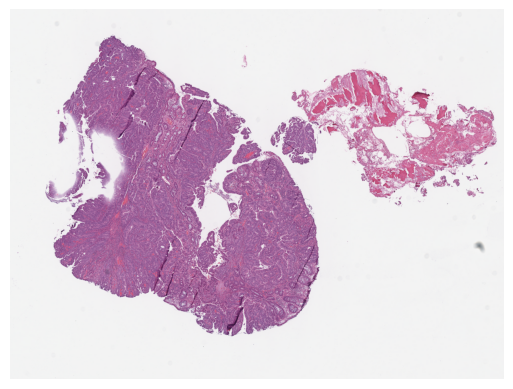

Visualization of 3 patches randomly sampled from ~10x imaging


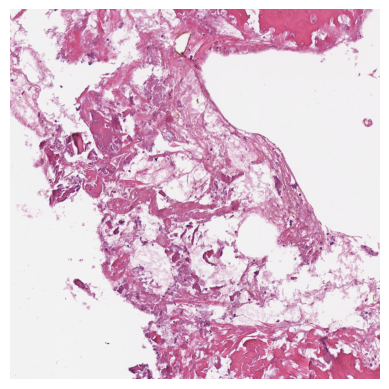

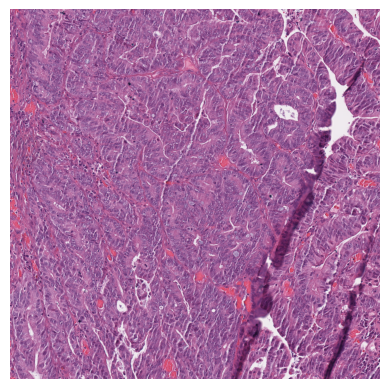

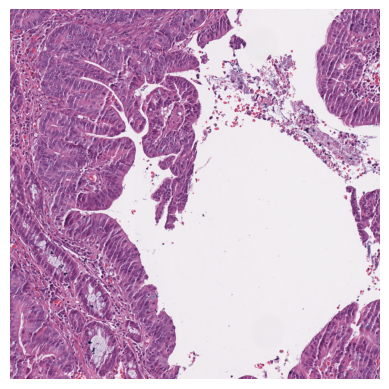

In [21]:
# @title Read patches of digital pathology imaging from the DICOM store.

import random

from ez_wsi_dicomweb import patch_generator
import matplotlib.pyplot as plt

# Maximum number of patches to retrieve from the slide imaging.
maximum_number_of_patches = 125
patch_size = 896  # MedGemma input image size.

# Generate patches from non-overlapping tissue containing regions.
patche_generator = patch_generator.DicomPatchGenerator(slide, level, patch_size=patch_size, stride_size=patch_size)
sampled_patches = [p for p in patche_generator]
sampled_patches = random.sample(sampled_patches, k=min(maximum_number_of_patches, len(sampled_patches)))

print("Low magnfication view of the slide imaging.")
plt.imshow(patche_generator.get_tissue_mask())
plt.axis("off")
plt.show()

print("Visualization of 3 patches randomly sampled from ~10x imaging")
for p in sampled_patches[:min(3, len(sampled_patches))]:
   plt.imshow(p.image_bytes()) # Display the image with a grayscale colormap
   plt.axis("off") # Optional: Turn off axis labels and ticks
   plt.show()

In [22]:
# @title Construct MedGemma 1.5 prompt formatted as a chat completion.

import base64
import io

import numpy as np
import PIL.Image

def _encode(data: np.ndarray) -> str:
  """Encode pathology patch imaging inline in prompt."""
  # Image format pathology patches are encoded as.
  # options: "jpeg" or "png"
  image_format = "jpeg"
  with PIL.Image.fromarray(data) as img:
      with io.BytesIO() as img_bytes:
        img.save(img_bytes, format=image_format)
        encoded_string = base64.b64encode(img_bytes.getvalue()).decode("utf-8")
  return f"data:image/{image_format};base64,{encoded_string}"

prompt = ("Provide a brief descriptive text for the set of pathology patches "
          "extracted from a pathology slide. Consider the tissue type and "
          "procedure (below) when deciding what to include in the descriptive "
          "text.\ncolon, biopsy:")

# Generate chat completion formatted prompt.
content = [{"type": "text", "text": prompt}]
for p in sampled_patches:
  content.append({"type": "image", "image": _encode(p.image_bytes())})

messages = [{"role": "user", "content": content}]


In [23]:
# @title Display full MedGemma 1.5 prompt.
import json

from IPython.display import display, Markdown


def truncate_prompt(obj, max_len):
  # Clip strings in prompt to avoid displaying excessively large content in Colab notebook.
  if isinstance(obj, dict):
    return {k: truncate_prompt(v, max_len) for k, v in obj.items()}
  elif isinstance(obj, list):
    return [truncate_prompt(elem, max_len) for elem in obj]
  elif isinstance(obj, str) and len(obj) > max_len:
    return obj[:max_len] + "..."  # Add ellipsis for truncated strings
  return obj

txt = json.dumps(truncate_prompt(messages, 100), indent=4, sort_keys=True)
display(Markdown(f"```json\n{txt}"))

```json
[
    {
        "content": [
            {
                "text": "Provide a brief descriptive text for the set of pathology patches extracted from a pathology slide. ...",
                "type": "text"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            },
            {
                "image": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aH...",
                "type": "image"
            }
        ],
        "role": "user"
    }
]

# Authenticate with Hugging Face

Generate a Hugging Face `read` access token by going to [settings](https://huggingface.co/settings/tokens).

If you are using Google Colab, add your access token to the Colab Secrets manager to securely store it. If not, proceed to run the cell below to authenticate with Hugging Face.

1. Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel. <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2. Create a new secret with the name `HF_TOKEN`.
3. Copy/paste your token key into the Value input box of `HF_TOKEN`.
4. Toggle the button on the left to allow notebook access to the secret.

In [24]:
import os
import sys


google_colab = "google.colab" in sys.modules and not os.environ.get("VERTEX_PRODUCT")

if google_colab:
    # Use secret if running in Google Colab
    from google.colab import userdata
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
else:
    # Store Hugging Face data under `/content` if running in Colab Enterprise
    if os.environ.get("VERTEX_PRODUCT") == "COLAB_ENTERPRISE":
        os.environ["HF_HOME"] = "/content/hf"
    # Authenticate with Hugging Face
    from huggingface_hub import get_token
    if get_token() is None:
        from huggingface_hub import notebook_login
        notebook_login()

In [25]:
# @title Load MedGemma 1.5 from Hugging Face Hub

import torch
import transformers

model_id = "google/medgemma-4b-1.5-staging"

model_kwargs = dict(
    dtype=torch.bfloat16,
    device_map="auto",
    offload_buffers=True,
)

processor = transformers.AutoProcessor.from_pretrained(model_id, use_fast=True,  **model_kwargs)
model = transformers.AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
# @title # Run MedGemma locally and return prediction

# Tokenize text + image prompt
inputs = processor.apply_chat_template(
                 messages,
                 add_generation_prompt=True,
                 continue_final_message=False,
                 return_tensors="pt",  # pytorch
                 tokenize=True,
                 return_dict=True,
             )


# Run generative model
with torch.inference_mode():
  inputs = inputs.to(model.device, dtype=torch.bfloat16)
  generated_sequence = model.generate(**inputs, do_sample=False, max_new_tokens=2000)

# Process response
medgemma_response = processor.post_process_image_text_to_text(generated_sequence, skip_special_tokens=True)
decoded_inputs = processor.post_process_image_text_to_text(inputs["input_ids"], skip_special_tokens=True)
medgemma_response = medgemma_response[0]
# There can be added characters before the input text, so we need to find the
# beginning of the input text in the generated text
index_input_text = medgemma_response.find(decoded_inputs[0])
if 0 <= index_input_text and index_input_text <= 2:
  # If the input text is found, we remove it
  medgemma_response = medgemma_response[index_input_text + len(decoded_inputs[0]):]

# Display result
display(Markdown(f"---\n\n**[ MedGemma ]**\n\n{medgemma_response}\n\n---"))

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


---

**[ MedGemma ]**

colon biopsy: moderately differentiated adenocarcinoma.

---